#HoG KNN for MNIST

##Import libraries

In [ ]:
#import libraries
import cv2

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

import tensorflow as tf

##Import and load data

In [ ]:
#mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#load mnist data from Google Drive
df_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/MNIST/train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/MNIST/labelledtest.csv")

##Preview data

In [ ]:
#display train dataframe
df_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
#train data stat
df_train.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.00000,42000.000000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,...,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00300,0.011190,0.005143,0.000214,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000381,0.001310,0.010548,0.027262,0.050905,0.066405,0.129571,...,3.772524,2.748905,1.796452,1.089905,0.563190,0.239571,0.093524,0.024833,0.000857,0.001405,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006143,0.035833,0.082357,0.114905,0.178714,0.301452,0.413643,0.513667,0.558833,0.677857,0.60281,0.489238,0.340214,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.56812,1.626927,1.053972,0.043916,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.078072,0.232634,1.131661,2.310396,3.121847,3.259128,4.992894,...,26.957829,22.879248,18.595109,14.434439,10.517823,6.469315,3.976306,1.846016,0.139556,0.287891,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.949803,2.350859,3.934280,4.543583,5.856772,7.219742,8.928286,10.004069,10.129595,11.254931,10.69603,9.480066,7.950251,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [ ]:
#display test dataframe
df_test.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
#test data stat
df_test.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,28000.000000,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,...,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.0,28000.0,28000.0,28000.0,28000.0
mean,4.446107,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001357,0.012500,0.016786,0.031714,0.056000,0.100464,...,3.272536,2.371464,1.454357,0.846286,0.509750,0.254750,0.062107,0.015250,0.000786,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005429,0.024179,0.036250,0.083143,0.134107,0.201071,0.325000,0.366714,0.468143,0.589429,0.656964,0.569714,0.464214,0.323679,0.164607,0.073214,0.028036,0.011250,0.006536,0.0,0.0,0.0,0.0,0.0
std,2.893929,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.227093,1.566275,1.513515,2.674449,3.216234,4.549478,...,25.211706,21.240003,16.643468,12.637953,9.963879,7.031504,3.040514,1.265562,0.131475,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.640468,2.234963,2.493982,3.777711,4.946940,6.262819,7.714814,8.243535,8.974038,10.488695,11.209508,10.204173,9.402197,7.878854,5.473293,3.616811,1.813602,1.205211,0.807475,0.0,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000

In [ ]:
df_train.info() #with label

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [ ]:
df_test.info() #missing label added

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 167.7 MB


In [ ]:
df_train.shape #training set shape

(42000, 785)

In [ ]:
df_test.shape #test set shape, missing label column

(28000, 785)

##Pre-processing

In [ ]:
X_train = df_train.drop('label', axis = 1) #drop label column
X_train = X_train.values.astype('float64') #convert to float 64
X_train #show

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
y_train = df_train['label'] #assign the label column to y
y_train = y_train.values.astype('int64') #convert to int 64
y_train #show

array([1, 0, 1, ..., 7, 6, 9])

In [ ]:
X_test = df_test.drop('label', axis = 1) #assign to the whole test set since label column is missing
X_test = X_test.values.astype('float64') #convert to float 64
X_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
y_test = df_test['label'] #assign the label column to y
y_test = y_test.values.astype('int64') #convert to int 64
y_test

array([2, 0, 9, ..., 3, 9, 2])

In [ ]:
resX_train = X_train.reshape(X_train.shape[0], 28, 28) #reshape to 28 x 28 (sqrt of 784)

In [ ]:
resX_test = X_test.reshape(X_test.shape[0], 28, 28) #reshape to 28 x 28 (sqrt of 784)

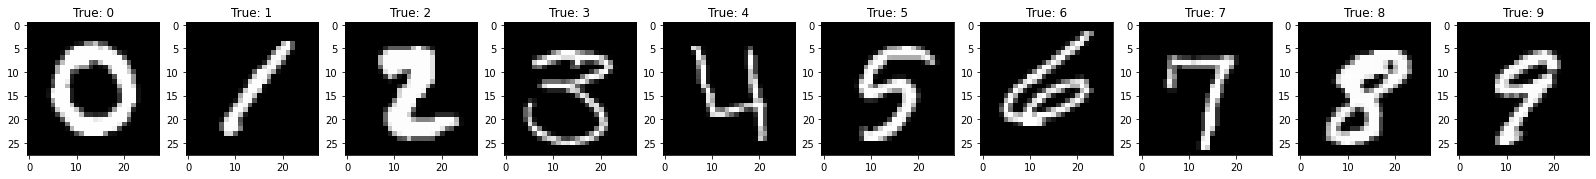

In [ ]:
#train image sampling
digit = 10
fig, axes = plt.subplots(1, digit, figsize=(28,28))

for i in range(0, digit):
  trainsamp = resX_train[y_train == i][0]
  axes[i].imshow(tf.squeeze(trainsamp), cmap = 'gray')
  axes[i].set_title("True: {}".format(i), fontsize = 12)

##Deskew

In [ ]:
#deskew function
def deskew(im):
  immom = cv2.moments(im) #image moments
  if abs(immom['mu02']) < 0: #prevent zero divi
    return im.copy()

  ratio = immom['mu11']/immom['mu02'] #ratio between 2 central 2nd order moments
  mat = np.float32([[1, ratio, -0.5*28*ratio], [0, 1, 0]]) #2x3 translate + shear matrix

  im = cv2.warpAffine(im, mat, (28, 28), flags=cv2.WARP_INVERSE_MAP | cv2.INTER_AREA) #linear reverse mapping

  return im

In [ ]:
#equate
dskewresX_train = resX_train
dskewresX_test = resX_test

In [ ]:
#deskew train
for i in range(dskewresX_train.shape[0]):
  dskewresX_train[i] = deskew(dskewresX_train[i]) #deskew train data

In [ ]:
#deskew test
for i in range(dskewresX_test.shape[0]):
  dskewresX_test[i] = deskew(dskewresX_test[i]) #deskew test data

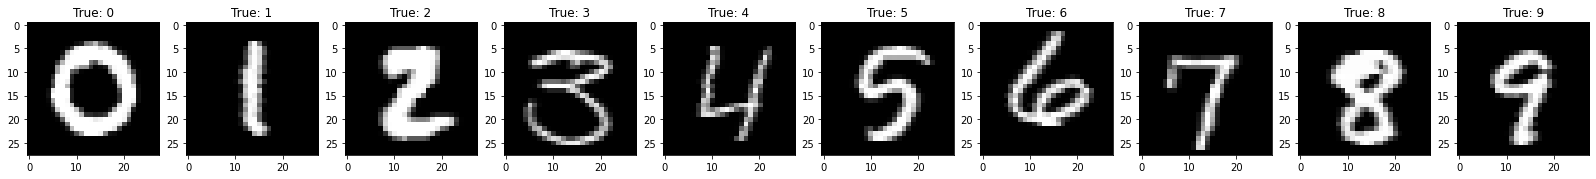

In [ ]:
#deskew train image sampling
digit = 10
fig, axes = plt.subplots(1, digit, figsize=(28,28))

for i in range(0, digit):
  dskewtrainsamp = dskewresX_train[y_train == i][0]
  axes[i].imshow(tf.squeeze(dskewtrainsamp), cmap = 'gray')
  axes[i].set_title("True: {}".format(i), fontsize = 12)

##Morphology

In [ ]:
kernel = np.matrix(('1 1'), np.uint8) #erosion kernel

In [ ]:
#for HoGKNNseries(deskew+erosion), use dskewresX_train
#for HoGKNNparallel(deskew+erosion), use resX_train
eroresX_train = cv2.erode(resX_train, kernel, iterations=1) #erosion of train data
#for HoGKNNseries(deskew+erosion), use dskewresX_test
#for HoGKNNparallel(deskew+erosion), use resX_test
eroresX_test = cv2.erode(resX_test, kernel, iterations=1) #erosion of test data

In [ ]:
len(eroresX_train) #length

42000

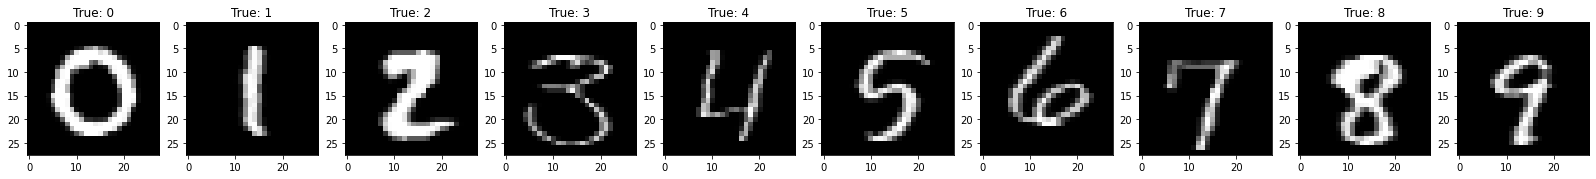

In [ ]:
#erosion train image sampling
digit = 10
fig, axes = plt.subplots(1, digit, figsize=(28,28))
for i in range(0, digit):
  erotrainsamp = eroresX_train[y_train == i][0]
  axes[i].imshow(tf.squeeze(erotrainsamp), cmap = 'gray')
  axes[i].set_title("True: {}".format(i), fontsize = 12)

##Concatenate

In [ ]:
#for HoGKNN(base), use resX_train
#for HoGKNN(deskew), use dskewresX_train
#for HoGKNNseries(deskew+erosion), use eroresX_train
#for HoGKNNparallel(deskew+erosion), use np.concatenate((dskewresX_train, eroresX_train),axis = 0)
newX_train = dskewresX_train
#for HoGKNN(base), use resX_test
#for HoGKNN(deskew), use dskewresX_test
#for HoGKNNseries(deskew+erosion), use eroresX_test
#for HoGKNNparallel(deskew+erosion), use np.concatenate((dskewresX_test, eroresX_test),axis = 0)
newX_test = dskewresX_test

In [ ]:
#new train data length
len(newX_train)

42000

In [ ]:
#new test data length
len(newX_test)

28000

In [ ]:
#for HoGKNN(base), use y_train
#for HoGKNN(deskew), use y_train
#for HoGKNNseries(deskew+erosion), use y_train
#for HoGKNNparallel(deskew+erosion), use np.concatenate((y_train, y_train),axis = 0)
newy_train = y_train
#for HoGKNN(base), use y_test
#for HoGKNN(deskew), use y_test
#for HoGKNNseries(deskew+erosion), use y_test
#for HoGKNNparallel(deskew+erosion), use np.concatenate((y_test, y_test),axis = 0)
newy_test = y_test

##HoG

In [ ]:
#hog parameters
winSize = (28, 28) #same as image size
blockSize = (12, 12) #12 x 12 block
blockStride = (4, 4) #4 by 4
cellSize = (12, 12) #12 x 12 cell
nbins = 9 #9 bins
signedGradients = True #0-180
derivAperture = 1 #default
winSigma = -1.0 #default
histogramNormType = 0 #none
L2HysThreshold = 0.2 #default
gammaCorrection = 1 #default
nlevels = 64 #default

In [ ]:
#hog descriptors
hog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins, derivAperture, winSigma, histogramNormType, L2HysThreshold, gammaCorrection, nlevels, signedGradients)

In [ ]:
#train data formatting
ui8resX_train = np.uint8(newX_train)

In [ ]:
#for train descriptors
train_descriptors = []
for i in range(ui8resX_train.shape[0]):
    traindescrip = hog.compute(ui8resX_train[i]) #hog for train data
    train_descriptors.append(traindescrip) #append to train decriptors list

In [ ]:
#length of train descriptors
len(train_descriptors[0])

225

In [ ]:
#train data resize
train_descriptors = np.resize(train_descriptors, (ui8resX_train.shape[0], 225))

In [ ]:
#test data formatting
ui8resX_test = np.uint8(newX_test)

In [ ]:
test_descriptors = []
for i in range(ui8resX_test.shape[0]):
    testdescrip = hog.compute(ui8resX_test[i]) # compute the HOG features
    test_descriptors.append(testdescrip) # append it to the test descriptors list

In [ ]:
#length of test descriptors
len(test_descriptors[0])

225

In [ ]:
#test descriptor resize
test_descriptors = np.resize(test_descriptors, (ui8resX_test.shape[0], 225))

##KNN

In [ ]:
newtrain_descriptors = train_descriptors #train
newtest_descriptors = test_descriptors #test

In [ ]:
#kfold params
k_num=[3,5,7] #odd k candidates
kfoldtrain_acc=[]
kftrain = KFold(n_splits = 4, random_state = 42, shuffle = True) #4-fold

In [ ]:
for k in k_num:
  classifier = KNeighborsClassifier(n_neighbors=k)
  kfacctrain_results = cross_val_score(classifier, newtrain_descriptors, newy_train, cv = kftrain, scoring = 'accuracy')
  kftrain_accuracy = np.mean(abs(kfacctrain_results))
  kfoldtrain_acc.append(kftrain_accuracy)

In [ ]:
#kfold train accuracy
print(kfoldtrain_acc)

[0.9894761904761904, 0.9896190476190476, 0.9890952380952381]


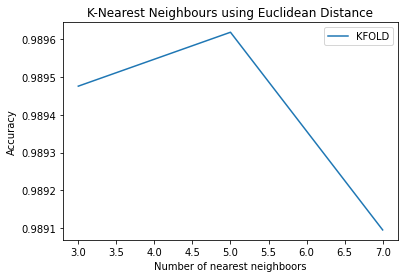

In [ ]:
#plotting
plt.plot(k_num, kfoldtrain_acc)
plt.title('K-Nearest Neighbours using Euclidean Distance')
plt.xlabel('Number of nearest neighboors')
plt.ylabel('Accuracy')
plt.legend(['KFOLD'], loc = 'best')
plt.show()

In [ ]:
#final classifier
finclassifier = KNeighborsClassifier(n_neighbors=5) #k = 5
finclassifier = finclassifier.fit(newtrain_descriptors, newy_train)

In [ ]:
#for test
finy_predtest = finclassifier.predict(newtest_descriptors)
test_cm = confusion_matrix(newy_test, finy_predtest)

In [ ]:
#for test
print(accuracy_score(newy_test, finy_predtest))
print(classification_report(newy_test, finy_predtest))
print(confusion_matrix(newy_test, finy_predtest))

0.9904285714285714
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      2771
           1       0.99      0.99      0.99      3193
           2       0.99      0.99      0.99      2813
           3       0.99      0.99      0.99      2790
           4       0.99      0.99      0.99      2752
           5       0.99      0.99      0.99      2518
           6       0.99      0.99      0.99      2739
           7       0.99      0.99      0.99      2892
           8       0.99      0.98      0.99      2762
           9       0.98      0.99      0.98      2770

    accuracy                           0.99     28000
   macro avg       0.99      0.99      0.99     28000
weighted avg       0.99      0.99      0.99     28000

[[2757    2    0    1    0    0    8    0    3    0]
 [   0 3167    6    0    1    0    2   13    1    3]
 [   4    1 2789    5    2    0    1    4    6    1]
 [   1    0    2 2769    0    2    0    6    9    1]
 [   0    

##Plotting

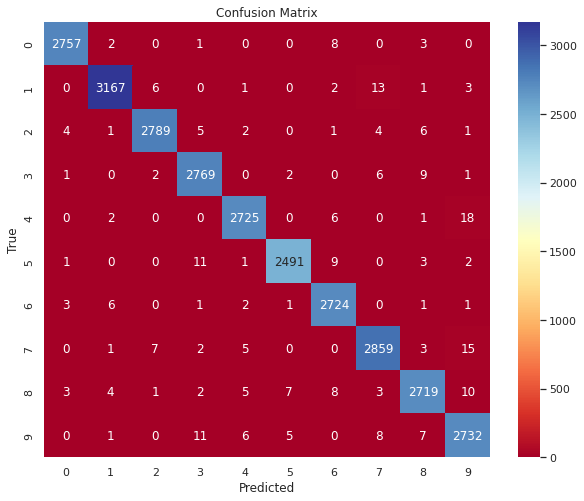

In [ ]:
#heatmap
pandas_cm = pd.DataFrame(test_cm, range(10), range(10)) #0 to 9
plt.figure(figsize=(10,8))
sns.set(font_scale=1) #for label size
sns.heatmap(pandas_cm, annot=True, fmt='g', cmap='RdYlBu') #non-scientific notation

#label
ax = plt.gca()
ax.set_xlabel('Predicted'); ax.set_ylabel('True');
ax.set_title('Confusion Matrix');

plt.show()

In [ ]:
#list of correct and error predictions
count = 0
error = []
correct = []
for true, predicted in zip(newy_test, finy_predtest):
  if true == predicted:
    correct.append(count)
  else:
    error.append(count)
  count = count + 1

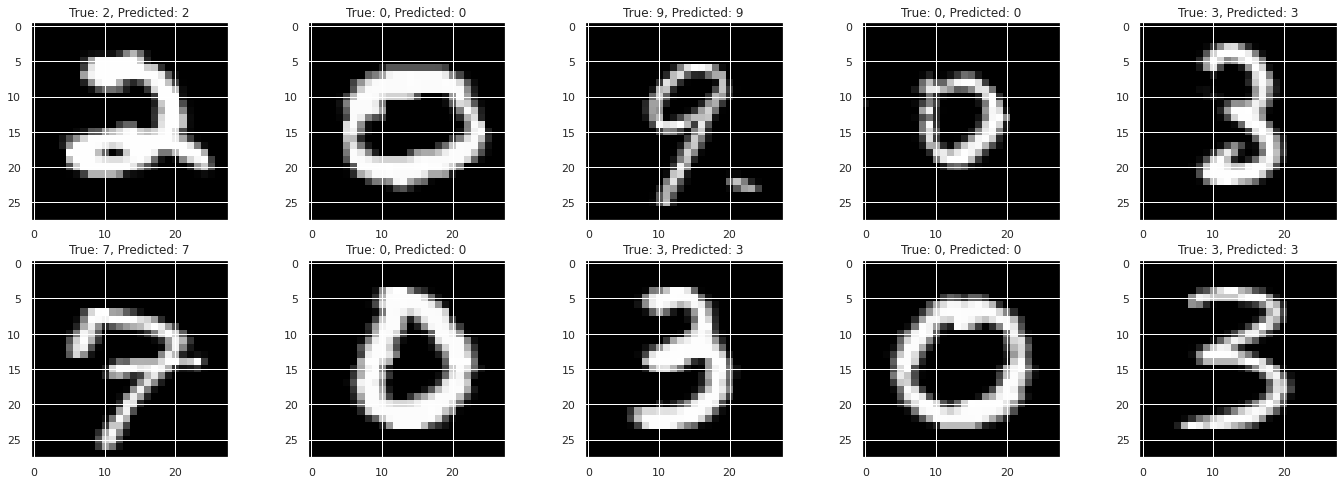

In [ ]:
#correct plotting
plt.figure(figsize=(24,8))
for i, j in enumerate(correct[0:10]):
  fig = plt.subplot(2, 5, i+1) #2x5 plot
  fig.imshow(dskewresX_test[j].reshape(28,28), cmap='gray')
  fig.set_title("True: {}, Predicted: {}" .format(newy_test[j], finy_predtest[j]))

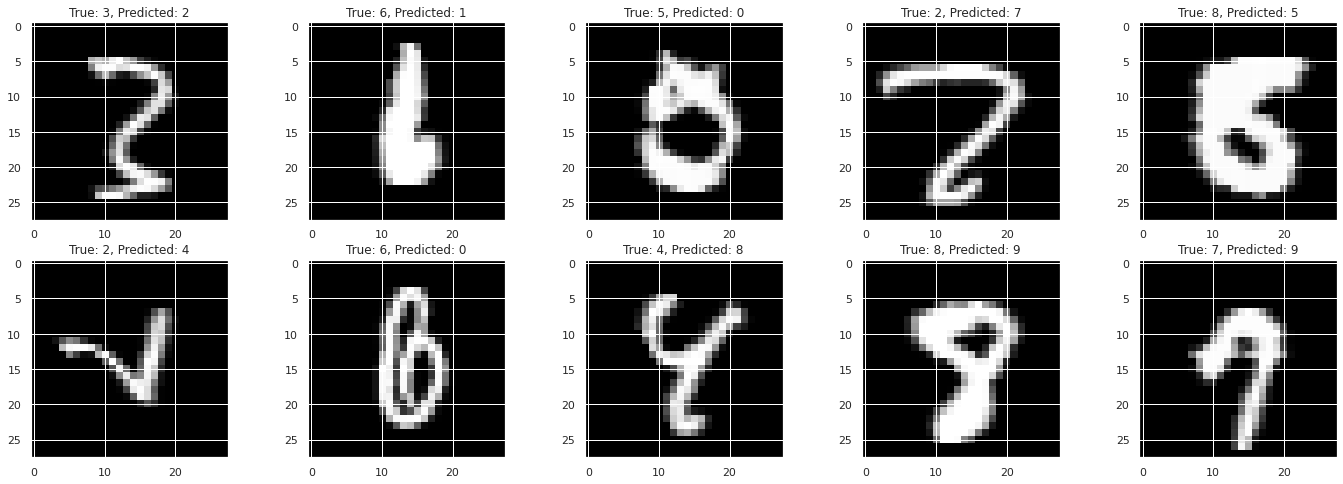

In [ ]:
#error plotting
plt.figure(figsize=(24,8))
for k, L in enumerate(error[0:10]):
  fig = plt.subplot(2, 5, k+1) #2x5 plot
  fig.imshow(dskewresX_test[L].reshape(28,28), cmap='gray')
  fig.set_title("True: {}, Predicted: {}" .format(newy_test[L], finy_predtest[L]))

In [ ]:
#correct list
print(correct)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222,

In [ ]:
#error list
print(error)

[165, 460, 554, 645, 789, 844, 1150, 1307, 1402, 1406, 1414, 1935, 2337, 2416, 2518, 2553, 2579, 2611, 2731, 3015, 3217, 3254, 3256, 3277, 3279, 3295, 3529, 3628, 3700, 3774, 3780, 3844, 3870, 4287, 4852, 5101, 5155, 5276, 5455, 5915, 6117, 6256, 6571, 6577, 6673, 6682, 6713, 6906, 6979, 7026, 7149, 7169, 7213, 7238, 7271, 7341, 7372, 7437, 7593, 8031, 8119, 8163, 8239, 8268, 8458, 8465, 8499, 8667, 8780, 8940, 9051, 9105, 9138, 9387, 9518, 9545, 9585, 9765, 9881, 9924, 9978, 10135, 10252, 10362, 10391, 10619, 10703, 10839, 10950, 10964, 11272, 11307, 11539, 11557, 11596, 11654, 11666, 11718, 11746, 11756, 12086, 12099, 12194, 12208, 12303, 12309, 12538, 12583, 12747, 13242, 13290, 13522, 13559, 13562, 13586, 13878, 14063, 14459, 14895, 14975, 15047, 15301, 15344, 15359, 15413, 15652, 15656, 15779, 15811, 15824, 16136, 16176, 16204, 16365, 16452, 16475, 16490, 16518, 16555, 16577, 16614, 16640, 16648, 16729, 17000, 17093, 17160, 17344, 17378, 17406, 17434, 17748, 17834, 17856, 17931, 1

#Kaggle submission

In [ ]:
y_pred_1 = finy_predtest #equate

In [ ]:
y_pred_1 #preview

array([2, 0, 9, ..., 3, 9, 2])

In [ ]:
len(y_pred_1) #check length

28000

In [ ]:
Out_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/MNIST/sample_submission.csv")

In [ ]:
Out_df['Label'] = y_pred_1

In [ ]:
Out_df.to_csv('submission_00.csv', index=False)

In [ ]:
Out_df.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
